# Кластеризация предложений

# Библиотеки

In [1]:
import json
import os
#from google.colab import drive
from tqdm import tqdm
import pickle
from collections import Counter
import time

import pandas as pd

import numpy as np
import scipy
from scipy import spatial

import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

# Функции

выделение кластера

In [2]:
def community_detection(embeddings, threshold=0.75, min_community_size=10, init_max_size=1000):
    """
    Function for Fast Community Detection
    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).
    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

отрисовка графика и понижение размерности

In [3]:
def plot_2d_representation_of_words(
    data, 
    flip_x_axis = False,
    flip_y_axis = False,
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    
    pca = PCA(n_components = 2)
    
    word_vectors = list(data[embedding])
    word_plus_coordinates = pd.DataFrame(word_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = pca.fit_transform(word_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)

    if flip_x_axis:
        coordinates_2d['x'] = \
        coordinates_2d['x'] * (-1)
    if flip_y_axis:
        coordinates_2d['y'] = \
        coordinates_2d['y'] * (-1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()

# Предобученная модель

Скачиваем предобученную модель

In [4]:
model = SentenceTransformer('bert-base-nli-mean-tokens') #эта быстрее
#model = SentenceTransformer('bert-large-nli-mean-tokens') #эта точнее

# Датасет трамп_байден2020 комментс

Проверям папку

In [5]:
comments_dir = r"\Users\Home\Documents\Data Science\comptech\2020_trump_biden"
os.listdir(comments_dir)[:5]

['JoeBiden_comments_2020_all.csv', 'Trump_comments_2020_all.csv']

In [6]:
%%time
d = dict()

for my_file in tqdm(os.listdir(comments_dir), position=0, leave=True):
    with open(os.path.join(comments_dir, my_file), encoding="utf8") as csv_file:
        d[my_file] = pd.read_csv(csv_file)

100%|██████████| 2/2 [00:05<00:00,  2.77s/it]

Wall time: 5.54 s


In [7]:
# add part column with trump
d['Trump_comments_2020_all.csv']['part'] = np.nan
d['Trump_comments_2020_all.csv']['part'] = d['Trump_comments_2020_all.csv']['part'].fillna('trump')

# add part column with biden
d['JoeBiden_comments_2020_all.csv']['part'] = np.nan
d['JoeBiden_comments_2020_all.csv']['part'] = d['JoeBiden_comments_2020_all.csv']['part'].fillna('biden')

In [8]:
comments_df = pd.concat([d['Trump_comments_2020_all.csv'], d['JoeBiden_comments_2020_all.csv']])
del(d)
comments_df.shape

(1494476, 8)

In [9]:
comments_df.sample(2)

Unnamed: 0       author  \
699068      699068  GGtorchwood   
195874      195874     __OHKO__   

                                                     body  created_utc  \
699068  As I thought, you had to dodge the issue. Prov...   1606283534   
195874  So why did they switch over? To own the libs? ...   1595823101   

          link_id   parent_id  score   part  
699068  t3_k0gi5q  t1_gdj058j    1.0  trump  
195874  t3_hy95l0  t1_fzdbxnk    1.0  biden

In [10]:
comments_df = comments_df.drop(['Unnamed: 0'], axis=1)

# Embedding

я пока не стала заморачиваться и делить попровну комменты байден и трам, но по идее надо

In [11]:
%%time
comments_df = comments_df.sample(20000)  # пробуем на маленькой выборке
comment_embedding = model.encode(comments_df['body'].to_list(), show_progress_bar=True, convert_to_numpy=True, device='cuda')
comments_df['embedding'] = list(comment_embedding)


Wall time: 43.7 s


Сохраняем таблице с вложениями

## что можно сделать:
1. поставить threshold 0.95 и вычленить все смайлы, односложные предлжения и ботов
2. удалить эти строки из датасета
3. прогнать кластеринг уже с threshold например 0.75 
4. нарисовать получившиеся кластеры

In [14]:
comments_df["label"] = np.nan
comments_df

author  \
130232             MazoMad22   
101604         cyka_blyat356   
52250                   bl1y   
382385  These-arent-my-pants   
234141               ArnaudL   
...                      ...   
524140         trumpndahouse   
315024          veryhotsoups   
208843         Greenmantle22   
304020               flurray   
485988     I_miss_your_mommy   

                                                     body  created_utc  \
130232                        How much did that cost you?   1582524153   
101604  Plus, Ford had no political motivation to make...   1588382245   
52250   Postponing a primary is a whole world away fro...   1584193559   
382385  I legit thought that was a woman at first. Aft...   1599771174   
234141  I support this idea for 100%! \n\nPlus, we kee...   1598095233   
...                                                   ...          ...   
524140  Ah yes ...the dumbass who spends the time they...   1603644962   
315024  I stopped watching halfway because I couldn't ...   1601438596   
208843  This is why Ms. Turner and Ms. Gray are not wh...   1596836351   
304020                            It's really not though.   1601191395   
485988  We all thought there was no way America would ...   1604495296   

          link_id   parent_id  score   part  \
130232  t3_f8f8xb   t3_f8f8xb    1.0  trump   
101604  t3_gbarea  t1_fp4v55c    1.0  biden   
52250   t3_fiaexc  t1_fkh9igp    1.0  biden   
382385  t3_iq4h0n   t3_iq4h0n    3.0  trump   
234141  t3_ieg1a6   t3_ieg1a6    1.0  biden   
...           ...         ...    ...    ...   
524140  t3_jhctuq  t1_ga2ma29    1.0  trump   
315024  t3_j2b7ze   t3_j2b7ze    1.0  biden   
208843  t3_i5g1wn  t1_g0ps5nz    1.0  biden   
304020  t3_j0jljh  t1_g6sltdo    1.0  biden   
485988  t3_jntymy  t1_gb40gi5    1.0  biden   

                                                embedding  label  
130232  [0.26363567, -0.92423916, 0.7973849, 0.7374179...    NaN  
101604  [-0.42481765, 0.4041819, 0.11679089, 0.0965682...    NaN  
52250   [-0.0010021867, 0.4345404, 1.0010695, 0.286333...    NaN  
382385  [0.3301106, 0.07899844, -0.5221299, 0.03733791...    NaN  
234141  [0.18234959, 0.49157217, 1.4095255, 0.22006579...    NaN  
...                                                   ...    ...  
524140  [0.058819324, 1.2488817, 0.96739703, 0.1727612...    NaN  
315024  [0.06488261, 0.7598329, 1.1382953, -0.07824627...    NaN  
208843  [-0.34110022, 0.9617984, 0.0055852574, 0.17715...    NaN  
304020  [0.6693773, -0.21565887, 1.8275903, 0.2368224,...    NaN  
485988  [-0.6158643, 0.1391162, 0.07068835, 0.12433389...    NaN  

[20000 rows x 9 columns]

1. Находим ненужные комменты (смайлы, да/нет, удаленные бото-сообщения, односложные предложения great!, not really! etc)

In [15]:
corpus_sentences = list(comments_df['body'])
corpus_embeddings = list(comments_df['embedding'])

print("Start clustering")
start_time = time.time()

#Two parameter to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements (30 similar sentences)
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = community_detection(corpus_embeddings, min_community_size=25, threshold=0.9)

print('Кол-во кластеров:', len(clusters))
for cluster in range(len(clusters)):
    print(f'Кол-во элементов в кластере {cluster}:', len(clusters[cluster]))

#Print all cluster / communities

for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster:
        print("\t", corpus_sentences[sentence_id])


print("Clustering done after {:.2f} sec".format(time.time() - start_time))

Start clustering
Кол-во кластеров: 15
Кол-во элементов в кластере 0: 322
Кол-во элементов в кластере 1: 231
Кол-во элементов в кластере 2: 194
Кол-во элементов в кластере 3: 166
Кол-во элементов в кластере 4: 142
Кол-во элементов в кластере 5: 135
Кол-во элементов в кластере 6: 130
Кол-во элементов в кластере 7: 65
Кол-во элементов в кластере 8: 64
Кол-во элементов в кластере 9: 59
Кол-во элементов в кластере 10: 53
Кол-во элементов в кластере 11: 53
Кол-во элементов в кластере 12: 49
Кол-во элементов в кластере 13: 44
Кол-во элементов в кластере 14: 28

Cluster 1, #322 Elements 
	 
This subreddit is a pro-Trump subreddit for sharing information about the 45th President Donald J Trump and the 2020 Presidential Election, as well as related materials.  While we encourage rational debate from all perspectives, we do not condone users engaging in hostilities, and expect that all participants follow the rules and remain civil at all times.

[ [Discord Chat](https://discord.gg/Trump2020) ] -

добавляем лейбл к таким сообщениям в нашем датасете

In [16]:
for i, cluster in enumerate(clusters):
    for row in cluster:
        try:
            comments_df.iloc[row, -1] = i
        except:
            pass

посмотрим сколько строк на удаление

In [17]:
comments_df[comments_df['label'].isnull() == False]['part'].count()

1735

удаляем

In [18]:
comments_df = comments_df[comments_df['label'].isnull() == True]

Теперь надо что-то сделать с размером комментариев чтобы можно было правильно кластеризоавать по теме, а не по размру. Варианты:
1. запихнуть все как есть и посмотеть что будет
2. Просто обрезать до 100 слов или примерно 500 символов
3. Как делали с вложениями слов, чтобы получить вложения предложений. Раздилить комментариий на предложения, создать эмбединги к каждому предложения, найти среднее и получим эмбединг для всего комментария. После обработки всех комментов, провести повторную кластеризацию 

1. 

In [19]:
corpus_sentences = list(comments_df['body'])
corpus_part = list(comments_df['part'])
corpus_embeddings = list(comments_df['embedding'])

print("Start clustering")
start_time = time.time()

#Two parameter to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements (30 similar sentences)
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = community_detection(corpus_embeddings, min_community_size=35, threshold=0.7)

print('Кол-во кластеров:', len(clusters))
for cluster in range(len(clusters)):
    print(f'Кол-во элементов в кластере {cluster}:', len(clusters[cluster]))

#Print all cluster / communities

for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster:
        print("\t", corpus_sentences[sentence_id])

print("Clustering done after {:.2f} sec".format(time.time() - start_time))

Start clustering
Кол-во кластеров: 15
Кол-во элементов в кластере 0: 3676
Кол-во элементов в кластере 1: 841
Кол-во элементов в кластере 2: 517
Кол-во элементов в кластере 3: 234
Кол-во элементов в кластере 4: 145
Кол-во элементов в кластере 5: 114
Кол-во элементов в кластере 6: 76
Кол-во элементов в кластере 7: 61
Кол-во элементов в кластере 8: 61
Кол-во элементов в кластере 9: 59
Кол-во элементов в кластере 10: 55
Кол-во элементов в кластере 11: 41
Кол-во элементов в кластере 12: 41
Кол-во элементов в кластере 13: 38
Кол-во элементов в кластере 14: 37

Cluster 1, #3676 Elements 
	 Plus, Ford had no political motivation to make the allegation. If the Senate didn’t confirm Kavanaugh, Trump would have just appointed someone else and they would have been confirmed. There was no way that Dr. Ford’s allegations could have politically changed the outcome. On the other hand, a Putin-loving Bernie supporter changing her story to make an allegation the minute the opponent of her preferred cand

In [20]:
for i, cluster in enumerate(clusters):
    for row in cluster:
        try:
            comments_df.iloc[row, -1] = i
        except:
            pass

C:\Users\Home\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [21]:
comments_df[comments_df['label'].isnull() == False]

author                                               body  \
101604      cyka_blyat356  Plus, Ford had no political motivation to make...   
52250                bl1y  Postponing a primary is a whole world away fro...   
234141            ArnaudL  I support this idea for 100%! \n\nPlus, we kee...   
205577     KD_Konkey_Dong  I just commented (disparagingly) about how wel...   
857494              JWF81  As funny as that could be I would prefer forme...   
...                   ...                                                ...   
289050    MountVernonWest  You said we are all racist. I was showing your...   
315024       veryhotsoups  I stopped watching halfway because I couldn't ...   
208843      Greenmantle22  This is why Ms. Turner and Ms. Gray are not wh...   
304020            flurray                            It's really not though.   
485988  I_miss_your_mommy  We all thought there was no way America would ...   

        created_utc    link_id   parent_id  score   part  \
101604   1588382245  t3_gbarea  t1_fp4v55c    1.0  biden   
52250    1584193559  t3_fiaexc  t1_fkh9igp    1.0  biden   
234141   1598095233  t3_ieg1a6   t3_ieg1a6    1.0  biden   
205577   1596601349  t3_i3fbtt   t3_i3fbtt    1.0  biden   
857494   1609428685  t3_knrpur   t3_knrpur    1.0  trump   
...             ...        ...         ...    ...    ...   
289050   1596671236  t3_i45x50  t1_g0i3zlw    1.0  trump   
315024   1601438596  t3_j2b7ze   t3_j2b7ze    1.0  biden   
208843   1596836351  t3_i5g1wn  t1_g0ps5nz    1.0  biden   
304020   1601191395  t3_j0jljh  t1_g6sltdo    1.0  biden   
485988   1604495296  t3_jntymy  t1_gb40gi5    1.0  biden   

                                                embedding  label  
101604  [-0.42481765, 0.4041819, 0.11679089, 0.0965682...    0.0  
52250   [-0.0010021867, 0.4345404, 1.0010695, 0.286333...    0.0  
234141  [0.18234959, 0.49157217, 1.4095255, 0.22006579...    3.0  
205577  [-0.53670955, 0.44718352, 0.45353973, 0.138916...    0.0  
857494  [-0.7018779, 0.9389478, 0.61141014, 0.19531503...    0.0  
...                                                   ...    ...  
289050  [0.06235777, 0.85789907, 0.059045117, 0.073052...    0.0  
315024  [0.06488261, 0.7598329, 1.1382953, -0.07824627...    0.0  
208843  [-0.34110022, 0.9617984, 0.0055852574, 0.17715...    0.0  
304020  [0.6693773, -0.21565887, 1.8275903, 0.2368224,...    2.0  
485988  [-0.6158643, 0.1391162, 0.07068835, 0.12433389...    0.0  

[5996 rows x 9 columns]

Распределение embedding размеченных данных

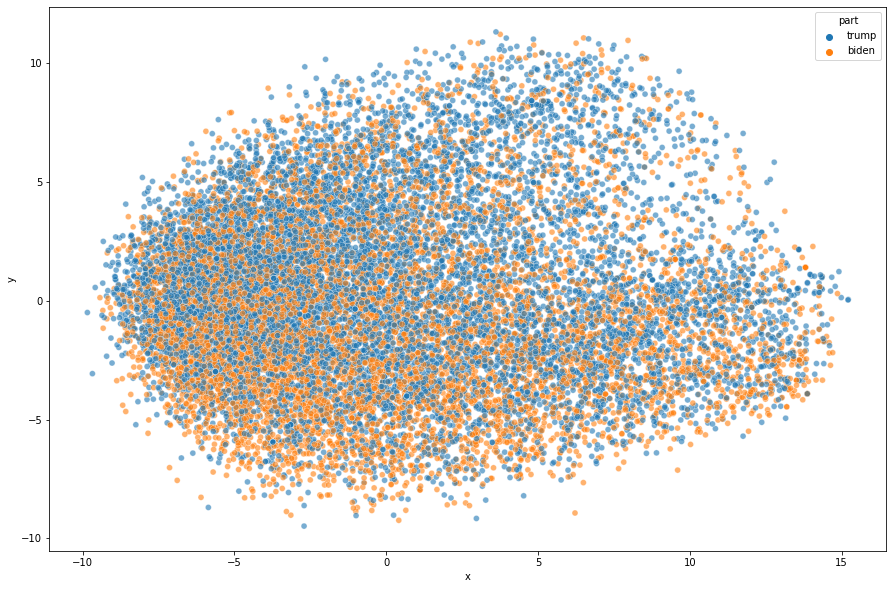

In [22]:
plot_2d_representation_of_words(comments_df, alpha=0.6, label='part')

Кластеры, которые нашлись по кос расстоянию

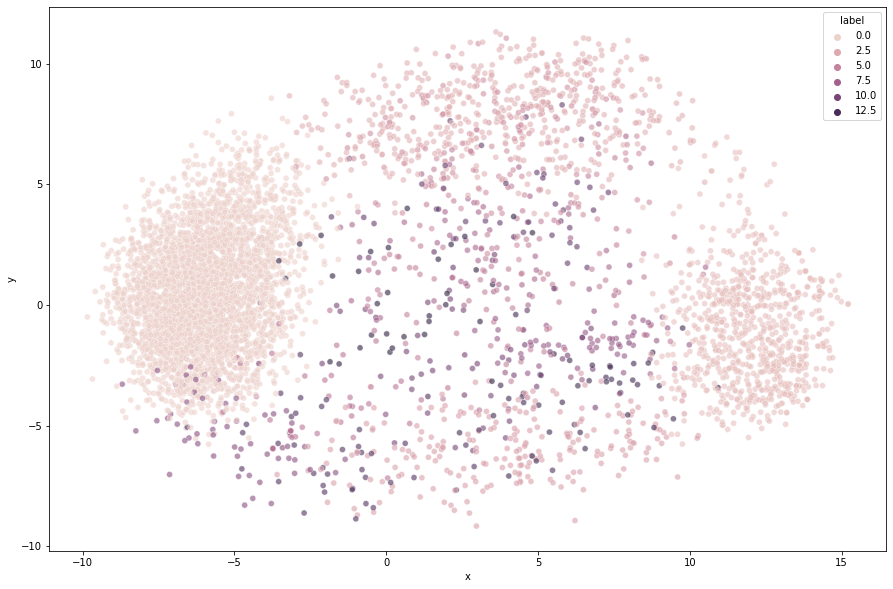

In [23]:
plot_2d_representation_of_words(comments_df, alpha=0.6)

## 2.

обрезаем комменты до 400 символов

In [24]:
comments_df = comments_df.reset_index(drop=True)
comments_df

author  \
0                 MazoMad22   
1             cyka_blyat356   
2                      bl1y   
3      These-arent-my-pants   
4                   ArnaudL   
...                     ...   
18260         trumpndahouse   
18261          veryhotsoups   
18262         Greenmantle22   
18263               flurray   
18264     I_miss_your_mommy   

                                                    body  created_utc  \
0                            How much did that cost you?   1582524153   
1      Plus, Ford had no political motivation to make...   1588382245   
2      Postponing a primary is a whole world away fro...   1584193559   
3      I legit thought that was a woman at first. Aft...   1599771174   
4      I support this idea for 100%! \n\nPlus, we kee...   1598095233   
...                                                  ...          ...   
18260  Ah yes ...the dumbass who spends the time they...   1603644962   
18261  I stopped watching halfway because I couldn't ...   1601438596   
18262  This is why Ms. Turner and Ms. Gray are not wh...   1596836351   
18263                            It's really not though.   1601191395   
18264  We all thought there was no way America would ...   1604495296   

         link_id   parent_id  score   part  \
0      t3_f8f8xb   t3_f8f8xb    1.0  trump   
1      t3_gbarea  t1_fp4v55c    1.0  biden   
2      t3_fiaexc  t1_fkh9igp    1.0  biden   
3      t3_iq4h0n   t3_iq4h0n    3.0  trump   
4      t3_ieg1a6   t3_ieg1a6    1.0  biden   
...          ...         ...    ...    ...   
18260  t3_jhctuq  t1_ga2ma29    1.0  trump   
18261  t3_j2b7ze   t3_j2b7ze    1.0  biden   
18262  t3_i5g1wn  t1_g0ps5nz    1.0  biden   
18263  t3_j0jljh  t1_g6sltdo    1.0  biden   
18264  t3_jntymy  t1_gb40gi5    1.0  biden   

                                               embedding  label  
0      [0.26363567, -0.92423916, 0.7973849, 0.7374179...    NaN  
1      [-0.42481765, 0.4041819, 0.11679089, 0.0965682...    0.0  
2      [-0.0010021867, 0.4345404, 1.0010695, 0.286333...    0.0  
3      [0.3301106, 0.07899844, -0.5221299, 0.03733791...    NaN  
4      [0.18234959, 0.49157217, 1.4095255, 0.22006579...    3.0  
...                                                  ...    ...  
18260  [0.058819324, 1.2488817, 0.96739703, 0.1727612...    NaN  
18261  [0.06488261, 0.7598329, 1.1382953, -0.07824627...    0.0  
18262  [-0.34110022, 0.9617984, 0.0055852574, 0.17715...    0.0  
18263  [0.6693773, -0.21565887, 1.8275903, 0.2368224,...    2.0  
18264  [-0.6158643, 0.1391162, 0.07068835, 0.12433389...    0.0  

[18265 rows x 9 columns]

In [26]:
def cut_the_comment(row):
    if len(row['body']) > 400:
        return row['body'][:400]
    else:
        return row['body']

In [33]:
comments_df['body'] = comments_df.apply(cut_the_comment, axis=1)

In [42]:
corpus_sentences = list(comments_df['body'])
corpus_embeddings = list(comments_df['embedding'])

print("Start clustering")
start_time = time.time()

#Two parameter to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements (30 similar sentences)
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = community_detection(corpus_embeddings, min_community_size=25, threshold=0.7)

print('Кол-во кластеров:', len(clusters))
for cluster in range(len(clusters)):
    print(f'Кол-во элементов в кластере {cluster}:', len(clusters[cluster]))

#Print all cluster / communities

for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster:
        print("\t", corpus_sentences[sentence_id])


print("Clustering done after {:.2f} sec".format(time.time() - start_time))

Start clustering
Кол-во кластеров: 18
Кол-во элементов в кластере 0: 3676
Кол-во элементов в кластере 1: 841
Кол-во элементов в кластере 2: 517
Кол-во элементов в кластере 3: 234
Кол-во элементов в кластере 4: 145
Кол-во элементов в кластере 5: 114
Кол-во элементов в кластере 6: 76
Кол-во элементов в кластере 7: 61
Кол-во элементов в кластере 8: 61
Кол-во элементов в кластере 9: 59
Кол-во элементов в кластере 10: 55
Кол-во элементов в кластере 11: 41
Кол-во элементов в кластере 12: 41
Кол-во элементов в кластере 13: 38
Кол-во элементов в кластере 14: 37
Кол-во элементов в кластере 15: 29
Кол-во элементов в кластере 16: 29
Кол-во элементов в кластере 17: 27

Cluster 1, #3676 Elements 
	 Plus, Ford had no political motivation to make the allegation. If the Senate didn’t confirm Kavanaugh, Trump would have just appointed someone else and they would have been confirmed. There was no way that Dr. Ford’s allegations could have politically changed the outcome. On the other hand, a Putin-lovin

In [48]:
four_clusters = comments_df[comments_df['label'] < 5]

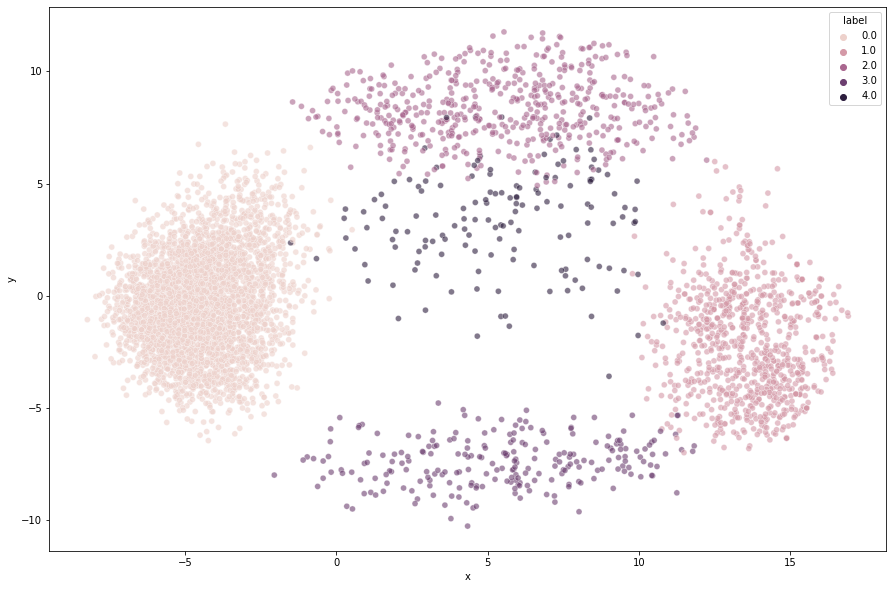

In [49]:
plot_2d_representation_of_words(four_clusters, alpha=0.6)

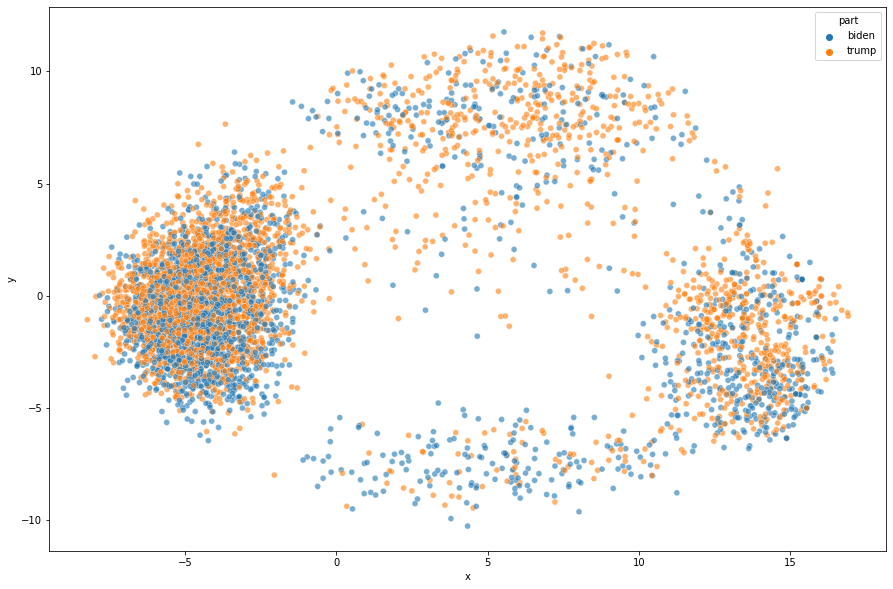

In [51]:
plot_2d_representation_of_words(four_clusters, alpha=0.6, label='part')